<a href="https://colab.research.google.com/github/vky342/DDPM---Butterfly/blob/main/ButterflyDDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from diffusers import UNet2DModel
from PIL import Image
from diffusers import DDPMScheduler
import torch.nn.functional as F
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
from IPython.display import display
from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup

In [ ]:
@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 30
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "<your-username>/<my-awesome-model>"
    hub_private_repo = None
    seed = 0

config = TrainingConfig()

In [ ]:
config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

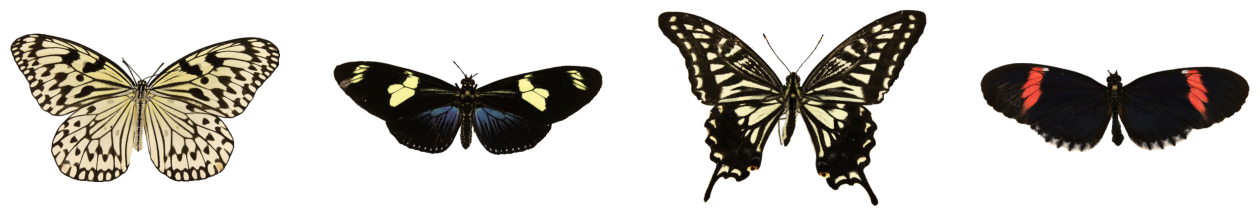

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


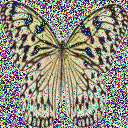

In [ ]:
#Setting the β
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])

# applying the noise to the image xt = βx0 + βε ; ε ~ N(0,1) ; xT ---> xT ~ N(0,1)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

tensor(1.0953, grad_fn=<MseLossBackward0>)


In [ ]:
def evaluate(config, epoch, pipeline):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device=device).manual_seed(config.seed),
    ).images

    image_grid = make_image_grid(images, rows=4, cols=4)

    display(image_grid)

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    global_step = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"].to(device)
            noise = torch.randn_like(clean_images)
            bs = clean_images.size(0)

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=device
            )

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()

            global_step += 1
            progress_bar.set_postfix(loss=loss.item(), lr=lr_scheduler.get_last_lr()[0])
            progress_bar.update(1)

        # Evaluate and save
        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
            evaluate(config, epoch, pipeline)

        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            model.save_pretrained(config.output_dir)

In [ ]:
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)